In [1]:
import sys
import os
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum
from metpy.calc import moist_static_energy, saturation_mixing_ratio, specific_humidity_from_mixing_ratio, parcel_profile, dewpoint_from_specific_humidity, dewpoint_from_relative_humidity
import metpy.constants
from metpy.units import units
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# Load dataset
exp_name = 'convective_coupling/aquaplanet/d5'
ds = isca_tools.load_dataset(exp_name)
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau = namelist['two_stream_gray_rad_nml']['atm_abs']
p_full = namelist['spectral_dynamics_nml']['reference_sea_level_press']     # pressure of entire atmosphere in Pa

## Spin up
The net flux converges, even if not exactly towards 0. I am still not sure if the $(1-\alpha \exp^{-\tau})$ prefactor is correct.
I use this prefactor because, on way from space to surface, shortwave radiation gets absorbed due to shortwave optical depth so
that the fraction of incoming that reaches the surface is $\exp^{-\tau}$.
A fraction $\alpha$ of this then gets reflected and returns to space.
[Isca](https://execlim.github.io/Isca/modules/two_stream_gray_rad.html#frierson-byrne-schemes) has no absorption of shortwave radiation of this upward reflected shortwave radiation.

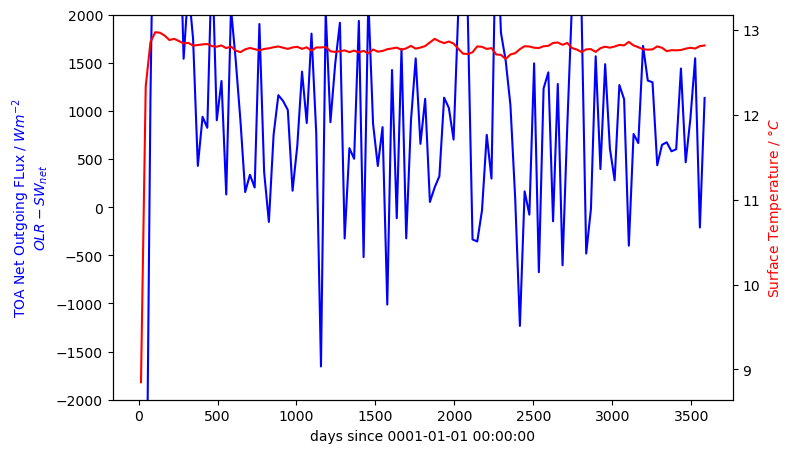

In [4]:
# Plot spin up time
fig, ax = plt.subplots(1,1, figsize=(8, 5))
# 101325 is the default reference pressure used by Isca if not set in the constants_nml module
isca_tools.plot.plot_spin_up(ds.olr, ds.swdn_toa*(1-albedo*np.exp(-tau*(p_full/101325)**4)), ds.temp_2m, ax)
ax.set_ylim([-2000, 2000]);

## Moist static energy
Want to see whether moist static energy is conserved i.e. same at surface and in free troposphere for each latitude.

In [5]:
# Take time and zonal mean
# Use all data after 3 years, as clearly converged from the above spin up plot
ds_use = ds.sel(time=slice(360*3, np.inf)).mean(dim=['lon', 'time'])

In [6]:
# Get near surface moist static energy as function of latitude using 2m variables
mse_2m = moist_static_energy(2 * units.meters, ds_use.temp_2m * units.kelvin,
                             ds_use.sphum_2m * units.kilogram/units.kilogram)

Max Surface Relative Humidity: 0.977


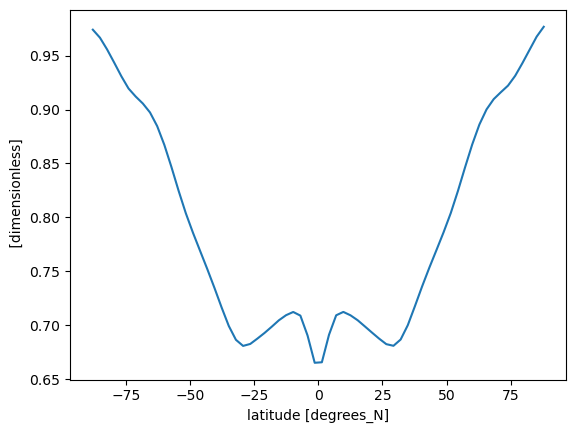

In [7]:
# Sanity check to make sure that surface specific humidity is less than saturation specific humidity.
# I.e. check that saturation q calculation is correct
q_sat_2m = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_use.temp_2m * units.kelvin))
rh_2m = ds_use.sphum_2m / q_sat_2m
rh_2m.plot()
print("Max Surface Relative Humidity: {:.3f}".format(rh_2m.to_numpy().max()))

In [8]:
# Free troposphere MSE at 700hPa - units of pressure in dataset are hPa
pressure_ft = 700  # pressure level of free troposphere in hPa
ds_ft = ds_use.sel(pfull=pressure_ft, method='nearest')
q_sat_ft = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_ft.temp * units.kelvin))
mse_ft = moist_static_energy(ds_ft.height * units.meters, ds_ft.temp * units.kelvin,
                             q_sat_ft * units.kilogram/units.kilogram)

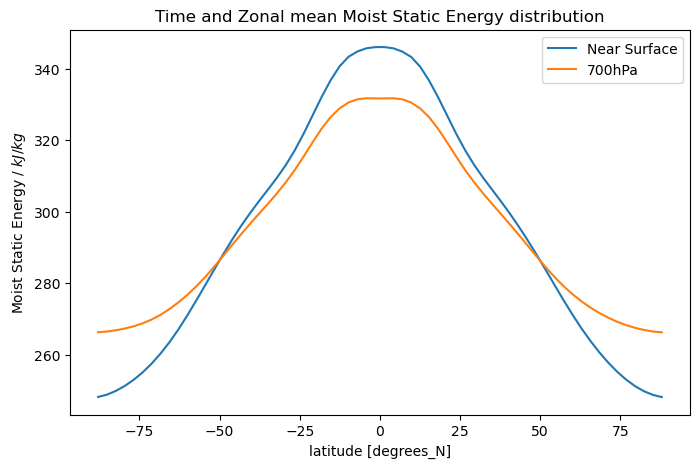

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
mse_2m.plot.line(ax=ax, add_legend=False, label="Near Surface")
mse_ft.plot.line(ax=ax, add_legend=False, label=f"{pressure_ft}hPa")
ax.legend();
ax.set_ylabel('Moist Static Energy / $kJ/kg$');
ax.set_title('Time and Zonal mean Moist Static Energy distribution');

This plot shows that the moist static energy at the surface is not equal to the saturation moist static energy in the free troposphere, as we would expect if it was convectively coupled.

In [10]:
# Consider each latitude and pressure value and compute saturation MSE
q_sat_all = specific_humidity_from_mixing_ratio(saturation_mixing_ratio(p_full * units.Pa, ds_use.temp * units.kelvin))
mse_all = moist_static_energy(ds_use.height * units.meters, ds_use.temp * units.kelvin,
                             q_sat_all * units.kilogram/units.kilogram)
mse_all.name = 'saturation moist static energy';

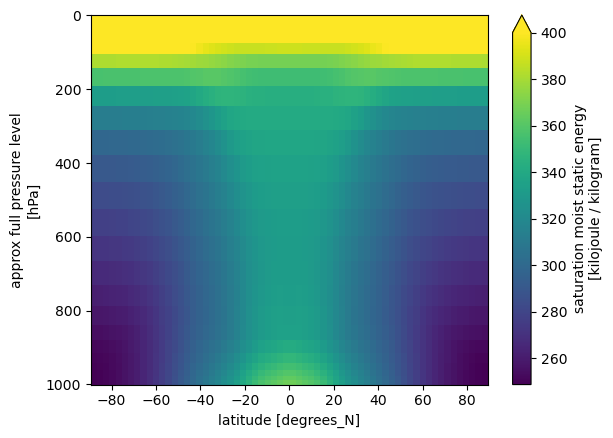

In [11]:
mse_all.plot(vmax=400, yincrease=False);

From this plot, it appears that in the tropics, the saturation MSE is constant from about 900hPa up to around 400hPa.

In [12]:
# Get data for plots
import warnings
# Fractional difference between surface MSE and saturation MSE at each pressure level
mse_diff = (mse_2m-mse_all)/mse_2m
mse_diff.name = '(Surface MSE - Saturation MSE)/Surface MSE'

# Tropical (|lat|<10) and extratropical (latitude between 40 and 60) lapse rates
trop_lapse = isca_tools.utils.area_weighting(ds_use.temp.sel(lat=slice(-10,10))).mean(dim='lat')
extrop_temp = xr.concat([ds_use.temp.sel(lat=slice(-60,-40)), ds_use.temp.sel(lat=slice(40,60))], dim='lat')
extrop_lapse = isca_tools.utils.area_weighting(extrop_temp).mean(dim='lat')

# Lapse rates which would occur if parcel followed dry adiabat to LCL followed by moist adiabat
trop_temp_2m = isca_tools.utils.area_weighting(ds_use.temp_2m.sel(lat=slice(-10,10))).mean(dim='lat')
trop_sphum_2m = isca_tools.utils.area_weighting(ds_use.sphum_2m.sel(lat=slice(-10,10))).mean(dim='lat')
trop_dew = dewpoint_from_specific_humidity(p_full*units.pascal, trop_temp_2m*units.kelvin,
                                           trop_sphum_2m*units.kilogram/units.kilogram)

extrop_temp_2m_all = xr.concat([ds_use.temp_2m.sel(lat=slice(-60,-40)), ds_use.temp_2m.sel(lat=slice(40,60))], dim='lat')
extrop_sphum_2m_all = xr.concat([ds_use.sphum_2m.sel(lat=slice(-60,-40)), ds_use.sphum_2m.sel(lat=slice(40,60))], dim='lat')
extrop_temp_2m = isca_tools.utils.area_weighting(extrop_temp_2m_all).mean(dim='lat')
extrop_sphum_2m = isca_tools.utils.area_weighting(extrop_sphum_2m_all).mean(dim='lat')
extrop_dew = dewpoint_from_specific_humidity(p_full*units.pascal, extrop_temp_2m*units.kelvin,
                                           extrop_sphum_2m*units.kilogram/units.kilogram)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    trop_profile = parcel_profile(extrop_temp.pfull[::-1] * units.hectopascal, trop_temp_2m*units.kelvin, trop_dew);
    extrop_profile = parcel_profile(extrop_temp.pfull[::-1] * units.hectopascal, extrop_temp_2m*units.kelvin, extrop_dew);
trop_profile.name = 'Temperature'
extrop_profile.name = 'Temperature'

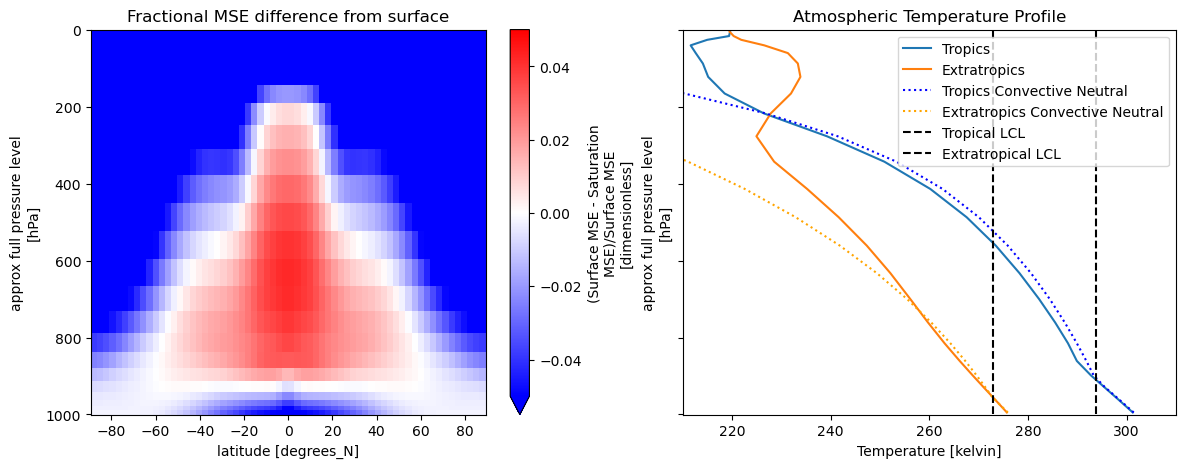

In [32]:
# Plot
fig, axs = plt.subplots(1,2, figsize=(14, 5), sharey=True)
# Plot fractional difference between surface MSE and saturation MSE at each pressure level
mse_diff.plot.pcolormesh(ax=axs[0], yincrease=False, vmin=-0.05, vmax=0.05, cmap='bwr', x='lat');
# Plot tropical (|lat|<10) and extratropical lapse rates
trop_lapse.plot.line(ax=axs[1], yincrease=False, y='pfull', label='Tropics');
extrop_lapse.plot.line(ax=axs[1], yincrease=False, y='pfull', label='Extratropics');
# Plot Lapse rates which would occur if parcel followed dry adiabat to LCL followed by moist adiabat
trop_profile.plot.line(ax=axs[1], yincrease=False, y='pfull', label='Tropics Convective Neutral', color='b',linestyle=':')
extrop_profile.plot.line(ax=axs[1], yincrease=False, y='pfull', label='Extratropics Convective Neutral', color='orange',linestyle=':')


axs[1].set_xlim([210, 310])
axs[0].set_title('Fractional MSE difference from surface');
axs[1].set_title('Atmospheric Temperature Profile');

# Compute LCL
trop_rh_2m = rh_from_sphum(trop_sphum_2m, trop_temp_2m, p_full)
trop_lcl = lcl_temp(trop_temp_2m, trop_rh_2m).to_numpy()
axs[1].vlines(trop_lcl,1000,0, linestyles='--',colors='k', label='Tropical LCL');

extrop_rh_2m = rh_from_sphum(extrop_sphum_2m, extrop_temp_2m, p_full)
extrop_lcl = lcl_temp(extrop_temp_2m, extrop_rh_2m).to_numpy()
axs[1].vlines(extrop_lcl,1000,0, linestyles='--',colors='k', label='Extratropical LCL');

axs[1].legend();

The above plot shows the difference between surface moist static energy and saturation moist static energy at each pressure level.

In the tropics, near the surface, surface MSE > saturation MSE. This is probably because here, the lapse rate is the dry adiabat so temperatures are decreasing rapidly with altitude and hence saturation MSE also decreases rapidly with altitude.

Above around 900hPa though, saturation MSE > surface MSE. This is probably because here the temperature is following the moist adiabat and so decreases less rapidly with altitude. I.e. the increase in geopotential height outweighs the decrease in temperature.

In the entire red region, which encompasses the free troposphere of the tropics, we see that the MSE is within 5% of the surface MSE.

Comparing the two plots above, it appears that in both the tropics and extratropics, the saturation MSE is slightly above the surface MSE for all pressure levels where the temperature profile follows that predicted by convective neutrality.

For the tropics ($|\phi| \leq 10$), this is up to 200hPa and for the extratropics ($40 \leq |\phi| \leq 60$), this is up to around 700hPa.

We also see from this that the LCL is too near the surface compared to the actual profile, but coincides well with where the MetPy lapse rate changes. This would make sense if the starting relative humidity I use in the LCL calculation is larger than it actually is in *Isca*, i.e. air would have to rise less to become saturated. From the *play/rh_calc* notebook, we do see that the starting relative humidity is over-estimated when calculated from specific humidity.

## Manual MSE Computation

The equation used to compute moist static energy in *MetPy* is:
$MSE = c_{pd}T + L_vq + gz$

This does not allow for the variation with specific humidity, $q$, of the heat capacity, $c_{pd}$. It also doesn't allow for the variation with temperature, $T$, of the latent heat of vaporization, $L_v$.

To see if these make a difference, I manually compute the $MSE$ using equations given in the *Colin Raymond* [2021 paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021GL096082): *On the Controlling Factors for Globally Extreme Humid Heat*.


In [41]:
# Manual computation of MSE
def mse_manual(temp, sphum, z):
    # Returns MSE in kJ/kg given temp in kelvin, sphum in kg/kg and z in meters.
    # Uses section 2.1 of Raymond 2021 extreme humid heat paper
    mix_ratio = sphum / (1-sphum)
    heat_cap = 1005.7 * (1-mix_ratio) + 1850 * mix_ratio * (1-mix_ratio)
    latent_heat_vap = 1.918e6 * (temp/(temp-33.91))
    mse = heat_cap * temp + latent_heat_vap * sphum + metpy.constants.g.magnitude * z
    return mse / 1000

mse_2m_manual = mse_manual(ds_use.temp_2m, ds_use.sphum_2m, 2)

In [82]:
def saturation_vap_pressure_manual(temp):
    # Returns saturation vapour pressure in Pa (assumes RH=1 so T_{dew} = T).
    # Uses equation (1) in Raymond 2021
    def vap_press_hot(temp2):
        return np.exp(34.494 - (4924.99/(temp2-36.05)))/(temp-168.15)**1.57
    def vap_press_cold(temp2):
        return np.exp(43.494 - (6545.8/(temp2+4.85)))/(temp+549.85)**2
    return xr.where(temp<=273.15, vap_press_cold(temp), vap_press_hot(temp))

def sphum_from_vap_pressure_manual(sat_pressure, surface_pressure):
    # Returns specific humidity in units of kg/kg
    mix_ratio = 0.62197 * (sat_pressure/(surface_pressure-sat_pressure))
    return mix_ratio / (1+mix_ratio)

sat_vap_pressure_ft = saturation_vap_pressure_manual(ds_ft.temp)
sat_sphum_ft = sphum_from_vap_pressure_manual(sat_vap_pressure_ft, p_full)
mse_ft_manual = mse_manual(ds_ft.temp, sat_sphum_ft, ds_ft.height)

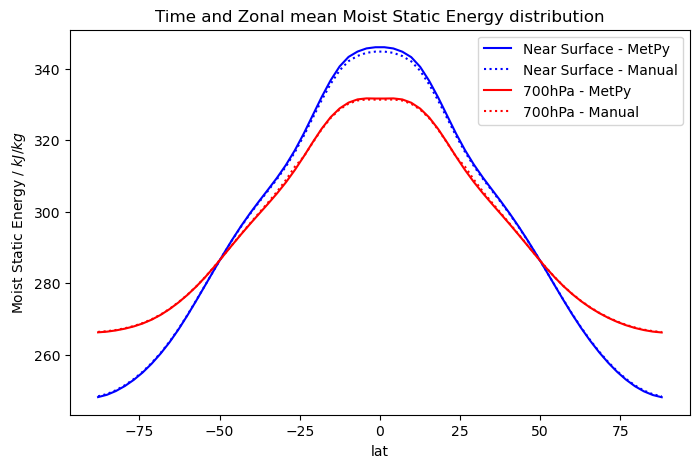

In [87]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
mse_2m.plot.line(ax=ax, add_legend=False, label="Near Surface - MetPy", color='blue')
mse_2m_manual.plot.line(ax=ax, add_legend=False, label="Near Surface - Manual", color='blue', linestyle=':')
mse_ft.plot.line(ax=ax, add_legend=False, label=f"{pressure_ft}hPa - MetPy", color='red')
mse_ft_manual.plot.line(ax=ax, add_legend=False, label=f"{pressure_ft}hPa - Manual", color='red', linestyle=':')
ax.legend();
ax.set_ylabel('Moist Static Energy / $kJ/kg$');
ax.set_title('Time and Zonal mean Moist Static Energy distribution');

Clearly, the *MetPy* calculation works very well.